# Using presamples with Brightway2  

This Notebook is meant to accompany the official documentation on [readthedocs](https://presamples.readthedocs.io/en/latest/use_with_bw2.html). 

The official documentation provides more context, but does not show all the code (e.g. it doesn't show the creation of LCI databases, the formatting of matrices for display, etc.).  
This Notebook contains all this extra code, but is much skimpier on context. You should probably read the official docs first, if you have not done so yet.   

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-required-modules" data-toc-modified-id="Importing-required-modules-1">Importing required modules</a></span></li><li><span><a href="#Formating-functions" data-toc-modified-id="Formating-functions-2">Formating functions</a></span></li><li><span><a href="#Biosphere-database" data-toc-modified-id="Biosphere-database-3">Biosphere database</a></span></li><li><span><a href="#LCIA-methods" data-toc-modified-id="LCIA-methods-4">LCIA methods</a></span></li><li><span><a href="#Example-1:----Static-scenario-analysis:-changing-supplier" data-toc-modified-id="Example-1:----Static-scenario-analysis:-changing-supplier-5">Example 1:  - Static scenario analysis: changing supplier</a></span><ul class="toc-item"><li><span><a href="#Writing-initial-database" data-toc-modified-id="Writing-initial-database-5.1">Writing initial database</a></span></li><li><span><a href="#Initial-system" data-toc-modified-id="Initial-system-5.2">Initial system</a></span></li><li><span><a href="#Scenario" data-toc-modified-id="Scenario-5.3">Scenario</a></span></li><li><span><a href="#matrix_data" data-toc-modified-id="matrix_data-5.4">matrix_data</a></span></li><li><span><a href="#Creating-presamples-package" data-toc-modified-id="Creating-presamples-package-5.5">Creating presamples package</a></span></li><li><span><a href="#Using-presamples-in-an-LCA" data-toc-modified-id="Using-presamples-in-an-LCA-5.6">Using presamples in an LCA</a></span><ul class="toc-item"><li><span><a href="#Without-presamples" data-toc-modified-id="Without-presamples-5.6.1">Without presamples</a></span></li><li><span><a href="#With-presamples" data-toc-modified-id="With-presamples-5.6.2">With presamples</a></span></li><li><span><a href="#Presamples-are-not-persistent" data-toc-modified-id="Presamples-are-not-persistent-5.6.3">Presamples are not persistent</a></span></li></ul></li></ul></li><li><span><a href="#Example-2---Using-presamples-for-time-series" data-toc-modified-id="Example-2---Using-presamples-for-time-series-6">Example 2 - Using presamples for time series</a></span></li><li><span><a href="#Example-3" data-toc-modified-id="Example-3-7">Example 3</a></span></li><li><span><a href="#Example-4---Balancing-sampled-exchange-values" data-toc-modified-id="Example-4---Balancing-sampled-exchange-values-8">Example 4 - Balancing sampled exchange values</a></span></li><li><span><a href="#LCA-matrices-and-the-case-for-using-presamples" data-toc-modified-id="LCA-matrices-and-the-case-for-using-presamples-9">LCA matrices and the case for using presamples</a></span></li><li><span><a href="#Defining-the-input-matrix_data" data-toc-modified-id="Defining-the-input-matrix_data-10">Defining the input matrix_data</a></span><ul class="toc-item"><li><span><a href="#Formating-functions-(Notebook-version-only)" data-toc-modified-id="Formating-functions-(Notebook-version-only)-10.1">Formating functions (Notebook version only)</a></span></li></ul></li><li><span><a href="#Example-1---Static-scenario-analysis:-changing-supplier" data-toc-modified-id="Example-1---Static-scenario-analysis:-changing-supplier-11">Example 1 - Static scenario analysis: changing supplier</a></span></li><li><span><a href="#Simple-database-used-in-documentation" data-toc-modified-id="Simple-database-used-in-documentation-12">Simple database used in documentation</a></span></li><li><span><a href="#Run-through" data-toc-modified-id="Run-through-13">Run through</a></span></li><li><span><a href="#Passing-matrix-data-to-presample-creation" data-toc-modified-id="Passing-matrix-data-to-presample-creation-14">Passing matrix data to presample creation</a></span></li><li><span><a href="#Using-presamples-in-LCA" data-toc-modified-id="Using-presamples-in-LCA-15">Using presamples in LCA</a></span></li><li><span><a href="#Using-presamples-in-MonteCarloLCA" data-toc-modified-id="Using-presamples-in-MonteCarloLCA-16">Using presamples in MonteCarloLCA</a></span></li><li><span><a href="#Fixed-sum-helper-model" data-toc-modified-id="Fixed-sum-helper-model-17">Fixed sum helper model</a></span></li><li><span><a href="#Kronecker-delta-helper-model" data-toc-modified-id="Kronecker-delta-helper-model-18">Kronecker delta helper model</a></span></li><li><span><a href="#Parameterized-brightway-models" data-toc-modified-id="Parameterized-brightway-models-19">Parameterized brightway models</a></span></li></ul></div>

## Importing required modules

In [30]:
# Principal modules
import presamples as ps
import brightway2 as bw
bw.projects.set_current("presamples doc")

In [2]:
# Other modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# The matrices used in the example are not sparse, so we ignore the SparseEfficiencyWarning
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning) 

## Formating functions
The following functions were written to format some of the objects that are encountered in LCA. 

They are of limited interest and can be skipped. 

In [4]:
# Format matrices to DataFrame
def format_matrices(database=None, demand=None, lca=None, simple=True):
    if lca is None:
        if demand is None:
            act = bw.Database(database).random()
            demand={act:act.get('production amount', 1)}
        lca = bw.LCA(demand)
    lca.lci()
    rev_activity_dict, rev_product_dict, rev_bio_dict = lca.reverse_dict()
    def get_name_with_units(act_key, simple):
        act = bw.get_activity(act_key)
        if simple: 
            return "\n{}\n{}\n".format(act.key, act['unit'])
        else:
            return "\n{} ({})\n{}\n".format(act['name'], act['unit'], act.key)
    
    col_names = [get_name_with_units(rev_activity_dict[i], simple) for i in np.arange(lca.inventory.shape[1])]
    techno_row_names = [get_name_with_units(rev_product_dict[i], simple) for i in np.arange(lca.technosphere_matrix.shape[0])]
    bio_row_names = [get_name_with_units(rev_bio_dict[i], simple) for i in np.arange(lca.biosphere_matrix.shape[0])]
    lca.demand_array = np.eye(lca.technosphere_matrix.shape[0])
    A_formatted = pd.DataFrame(index=techno_row_names, columns=col_names, data=lca.technosphere_matrix.todense())
    B_formatted = pd.DataFrame(index=bio_row_names, columns=col_names, data=lca.biosphere_matrix.todense())
    S = lca.solve_linear_system()
    G = lca.biosphere_matrix * S
    invA_formatted = pd.DataFrame(index=col_names, columns=techno_row_names, data=S)
    G_formatted = pd.DataFrame(index=bio_row_names, columns=col_names, data=G)
    return A_formatted, B_formatted, invA_formatted, G_formatted

# Format matrices to figure
def matrix_to_plot(matrix_as_df, return_fig=True, title=None, save_path=None, title_size=14, scaling_ratio=10):
    w = 2 + matrix_as_df.shape[1]/scaling_ratio
    h = 2 + matrix_as_df.shape[0]/scaling_ratio
    plt.figure(figsize=(w,h))
    matrix_plot = sns.heatmap(
        matrix_as_df, annot=True, cbar=False, cmap=(['white']), 
        mask=(matrix_as_df==0).values, linewidths=1, linecolor='grey',
        square=True
    )
    fig = matrix_plot.get_figure()
    if title:
        plt.title(title, fontsize=title_size)
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", ext="jpg")
    if return_fig:
        return fig

## Biosphere database

In [ ]:
bio = bw.Database("bio")
bio.register()
bio.write({
    ("bio", "emission"): {
        'categories': ['water'],
        'name': 'Some emission',
        'type': 'emission',
        'unit': 'kg'
    },
    ("bio", "water in"): {
        'categories': ['natural resource'],
        'exchanges': [],
        'name': 'Water in',
        'type': 'natural resource',
        'unit': 'm3'
    },
    ("bio", "water out"): {
        'categories': ['water'],
        'exchanges': [],
        'name': 'Water out',
        'type': 'emission',
        'unit': 'm3'
    },
    ("bio", "land from"): {
        'categories': ('natural resource', 'land'),
        'exchanges': [],
        'name': 'Transformation, from x',
        'type': 'natural resource',
        'unit': 'm2'
    },
    ("bio", "land to"): {
        'categories': ('natural resource', 'land'),
        'exchanges': [],
        'name': 'Transformation, to y',
        'type': 'natural resource',
        'unit': 'm2'
    },
})

## LCIA methods

In [ ]:
# For pollutants
m_name = ("mock method", "pollutant emission")
bw.Method(m_name).register()
m_as_method = bw.Method(m_name)
m_as_method.metadata['unit'] = "kg_eq emission"
data_as_list = [(('bio', 'emission'), 1)]
m_as_method.write(data_as_list)

# For water use
m_name = ("mock method", "water use")
bw.Method(m_name).register()
m_as_method = bw.Method(m_name)
m_as_method.metadata['unit'] = "m3 water"
data_as_list = [
    (('bio', 'water in'), 1), 
    (('bio', 'water out'), -1)
]
m_as_method.write(data_as_list)

# For land transformation
m_name = ("mock method", "land transformation")
bw.Method(m_name).register()
m_as_method = bw.Method(m_name)
m_as_method.metadata['unit'] = "m2 land"
data_as_list = [
    (('bio', 'land from'), 1), 
    (('bio', 'land to'), -0.5)
]
m_as_method.write(data_as_list)

## Example 1:  - Static scenario analysis: changing supplier

Accompanies the [corresponding section of the ReadTheDocs](https://presamples.readthedocs.io/en/latest/use_with_bw2.html#bw2_eg1)

### Writing initial database

In [ ]:
# Writing database
my_db = bw.Database('db1')
my_db.register()
my_db.write({
    ('db1', 'a1'): {
        'type': 'process',
        'name': 'Production A1',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'A',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'comment': 'represents cradle-to-gate LCI',
        'exchanges': [
            {
                'name': 'A',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db1', 'a1'),
                'type': 'production',
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 2,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
            },
        ],
    },
    ('db1', 'a2'): {
        'type': 'process',
        'name': 'Production A2',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'A',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'comment': 'represents cradle-to-gate LCI',
        'exchanges': [
            {
                'name': 'A',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db1', 'a2'),
                'type': 'production',
                'uncertainty type': 0,
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 1,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
            },

        ],
    },
    ('db1', "b"): {
        'type': 'process',
        'name': 'Producer b',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'b',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'exchanges': [
            {
                'name': 'b',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db1', 'b'),
                'type': 'production',
                'uncertainty type': 0,
            },
            {
                'name': 'A',
                'unit': 'kg',
                'amount': 0.6,
                'input': ('db1', 'a1'),
                'type': 'technosphere',
            },
            {
                'name': 'A',
                'unit': 'kg',
                'amount': 0.4,
                'input': ('db1', 'a2'),
                'type': 'technosphere',
            },
        ],
    },
})

### Initial system

**Initial product system**: 
![bw2_eg1_ps_initial](../source/images/bw2_eg1a.jpg)

**Initial A matrix**:

In [ ]:
A, _, _, _ = format_matrices(database='db1', simple=True)
matrix_to_plot(A, return_fig=True, title="Technosphere matrix \n$\mathbf{A}$", save_path=r"../source/images/bw2_eg1_A_orig.jpg");

### Scenario

![bw2_eg1_ps_initial](../source/images/bw2_eg1b.jpg)

### matrix_data

In [48]:
scenario_array = np.array(
    [
        1,    # New value for exchange between ('db1', 'a2') and ('db1', 'b')
        0     # New value for exchange between ('db1', 'a1') and ('db1', 'b')
    ]).reshape(-1, 1)

In [49]:
scenario_indices = [
    (('db1', 'a2'), ('db1', 'b'), 'technosphere'),
    (('db1', 'a1'), ('db1', 'b'), 'technosphere')
]

In [50]:
scenario_matrix_data = [(scenario_array, scenario_indices, 'technosphere')]

### Creating presamples package

In [51]:
scen_pp_id, scen_pp_path = ps.create_presamples_package(
    matrix_data = scenario_matrix_data,
    )

In [52]:
scen_pp_path

WindowsPath('C:/Users/Pascal Lesage/AppData/Local/pylca/Brightway3/presamples-doc.87bb6f1bead9da928ddd02994ff7f192/presamples/954e60062a534c38b22f82a6f30fdba2')

### Using presamples in an LCA

#### Without presamples

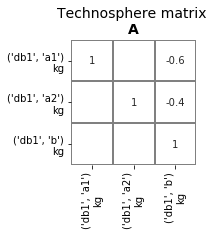

In [56]:
# LCA without presamples
lca_wo = bw.LCA(demand={('db1', 'b'): 1})
lca_wo.load_lci_data()
A_wo, _, _, _ = format_matrices(lca=lca_wo)
matrix_to_plot(A_wo, title="Technosphere matrix \n$\mathbf{A}$", save_path=r"../source/images/bw2_eg1_A_without_ps.jpg");

#### With presamples

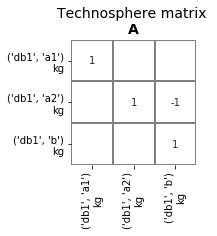

In [57]:
# LCA with presamples
lca_w = bw.LCA(demand={('db1', 'b'): 1}, presamples=[scen_pp_path])
lca_w.load_lci_data()
A_w, _, _, _ = format_matrices(lca=lca_w)
matrix_to_plot(A_w, title="Technosphere matrix \n$\mathbf{A}$", save_path=r"../source/images/bw2_eg1_A_with_ps.jpg");

#### Presamples are not persistent

In [ ]:
# LCA without presamples
lca_wo = bw.LCA(demand={('db1', 'b'): 1})
lca_wo.load_lci_data()
A_wo, _, _, _ = format_matrices(lca=lca_wo)
matrix_to_plot(A_wo);

## Example 2 - Using presamples for time series

**Context**

Supply of a varies over time:

<img src="../source/images/bw2_eg2_data.jpg" width="300">

**matrix_data**

In [5]:
time_array = np.array(
    [
        [0.9, 0.8, 0.6, 0.3, 0.6, 0.5],#, 0.9, 1, 0.9, 1, 0.8, 0.6, 0.4, 0.2],
        [0.1, 0.2, 0.4, 0.7, 0.4, 0.5]#, 0.1, 0, 0.1, 0, 0.2, 0.4, 0.6, 0.8]
    ]
)
time_array.shape

(2, 6)

In [6]:
time_indices = [
    (('db1', 'a2'), ('db1', 'b'), 'technosphere'),
    (('db1', 'a1'), ('db1', 'b'), 'technosphere')
]

In [7]:
time_matrix_data = [(time_array, time_indices, 'technosphere')]

**create presamples package**

In [8]:
time_pp_id, time_pp_path = ps.create_presamples_package(
    matrix_data = time_matrix_data,
    seed='sequential'
    )

**LCA**

In [9]:
lca = bw.LCA({('db1', 'b'):1}, presamples=[time_pp_path], method=("mock method", "pollutant emission"))

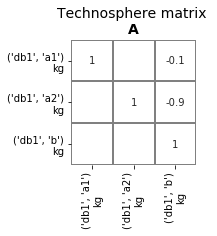

In [85]:
lca.lci()
A, _, _, _ = format_matrices(lca=lca)
matrix_to_plot(A, title="Technosphere matrix \n$\mathbf{A}$", save_path=r"../source/images/bw2_eg2_A0.jpg");

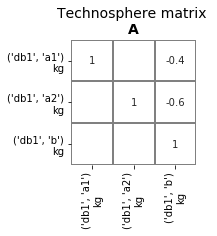

In [87]:
lca.presamples.update_matrices()
A, _, _, _ = format_matrices(lca=lca)
matrix_to_plot(A, title="Technosphere matrix \n$\mathbf{A}$", save_path=r"../source/images/bw2_eg2_A1.jpg");

In [88]:
lca = bw.LCA({('db1', 'b'):1}, presamples=[time_pp_path])
print("Times updated\tIndex value\tInput from a1\tInput from a2")
for i in range(10):
    if i == 0:
        lca.lci()
    else:
        lca.presamples.update_matrices()
    from_a1 = lca.technosphere_matrix[
        lca.product_dict[('db1', 'a1')], 
        lca.activity_dict[('db1', 'b')]
    ]
    from_a2 = lca.technosphere_matrix[
        lca.product_dict[('db1', 'a2')], 
        lca.activity_dict[('db1', 'b')]
    ]
    index_value = lca.presamples.matrix_indexer[0].index
    print(i, "\t\t", index_value, "\t\t", from_a1, "\t\t", from_a2)

Times updated	Index value	Input from a1	Input from a2
0 		 0 		 -0.1 		 -0.9
1 		 1 		 -0.2 		 -0.8
2 		 2 		 -0.4 		 -0.6
3 		 3 		 -0.7 		 -0.3
4 		 4 		 -0.4 		 -0.6
5 		 5 		 -0.5 		 -0.5
6 		 0 		 -0.1 		 -0.9
7 		 1 		 -0.2 		 -0.8
8 		 2 		 -0.4 		 -0.6
9 		 3 		 -0.7 		 -0.3


In [106]:
lca = bw.LCA({('db1', 'b'):1}, presamples=[time_pp_path], method=("mock method", "pollutant emission"))
for i in range(6):
    if i == 0:
        lca.lci()
        lca.lcia()
    else:
        lca.presamples.update_matrices()
        lca.redo_lci()
        lca.redo_lcia()
    print(i, lca.score)

0 1.1
1 1.2000000000000002
2 1.4
3 1.7
4 1.4
5 1.5


In [100]:
time_not_seq_pp_id, time_not_seq_pp_path = ps.create_presamples_package(
    matrix_data = time_matrix_data,
    seed=42
    )

In [101]:
lca = bw.LCA({('db1', 'b'):1}, presamples=[time_not_seq_pp_path])
print("Times updated\tIndex value\tInput from a1\tInput from a2")
for i in range(10):
    if i == 0:
        lca.lci()
    else:
        lca.presamples.update_matrices()
    from_a1 = lca.technosphere_matrix[
        lca.product_dict[('db1', 'a1')], 
        lca.activity_dict[('db1', 'b')]
    ]
    from_a2 = lca.technosphere_matrix[
        lca.product_dict[('db1', 'a2')], 
        lca.activity_dict[('db1', 'b')]
    ]
    index_value = lca.presamples.matrix_indexer[0].index
    print(i, "\t\t", index_value, "\t\t", from_a1, "\t\t", from_a2)

Times updated	Index value	Input from a1	Input from a2
0 		 0 		 -0.1 		 -0.9
1 		 3 		 -0.7 		 -0.3
2 		 2 		 -0.4 		 -0.6
3 		 4 		 -0.4 		 -0.6
4 		 4 		 -0.4 		 -0.6
5 		 3 		 -0.7 		 -0.3
6 		 2 		 -0.4 		 -0.6
7 		 0 		 -0.1 		 -0.9
8 		 4 		 -0.4 		 -0.6
9 		 5 		 -0.5 		 -0.5


## Example 3

Before:

![bw2_eg3_ps_initial](../source/images/bw2_eg3_before.jpg)

After:

![bw2_eg3_ps_after](../source/images/bw2_eg3_after.jpg)

In [11]:
# Writing database
my_db = bw.Database('db2')
my_db.register()
my_db.write({
    ('db2', 'a'): {
        'type': 'process',
        'name': 'Production a',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'A',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'comment': 'represents cradle-to-gate LCI',
        'exchanges': [
            {
                'name': 'A',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db2', 'a'),
                'type': 'production',
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 0.5,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
            },
        ],
    },
    ('db2', "b"): {
        'type': 'process',
        'name': 'Producer b',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'b',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'exchanges': [
            {
                'name': 'b',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db2', 'b'),
                'type': 'production',
                'uncertainty type': 0,
            },
            {
                'name': 'A',
                'unit': 'kg',
                'amount': 1,
                'input': ('db2', 'a'),
                'type': 'technosphere',
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 0.6,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
            },
        ],
    },
})

Writing activities to SQLite3 database:
0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/10/2020 22:01:56
  Finished: 03/10/2020 22:01:56
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 0.88


In [12]:
eg3_matrix_data = [
    (
        np.array([1.2]).reshape(1, 1), # Only one value, but array still needs to have two dimensions
        [(('db2', 'a'), ('db2', 'b'), 'technosphere')],
        'technosphere'
    ),
    (
        np.array([0.4]).reshape(1, 1), # Again, only one value
        [(('bio', 'emission'), ('db2', 'b')),], # No need to specify the exchange type, there is only one type
        'biosphere'
    )
]

In [13]:
eg3_pp_id, eg3_pp_path = ps.create_presamples_package(matrix_data = eg3_matrix_data)

In [14]:
lca0 = bw.LCA({('db2', 'b'):1}, method=('mock method', 'pollutant emission'))
lca1 = bw.LCA({('db2', 'b'):1}, method=('mock method', 'pollutant emission'), presamples=[eg3_pp_path])

In [15]:
lca0.lci()
lca0.lcia()
lca1.lci()
lca1.lcia()

In [16]:
lca1.score/lca0.score

0.9090908893868948

## Example 4 - Balancing sampled exchange values

In [31]:
# Writing database
my_db = bw.Database('db3')
my_db.register()
my_db.write({
    ('db3', 'a'): {
        'type': 'process',
        'name': 'Production a',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'A',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'exchanges': [
            {
                'name': 'A',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db3', 'a'),
                'type': 'production',
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 3,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
                'uncertainty type': 2,
                'loc': np.log(3),
                'scale': np.log(np.sqrt(1.2)),
            },
            {
                'name': 'fuel',
                'unit': 'kg',
                'amount': 1,
                'input': ('db3', 'fuel'),
                'type': 'technosphere',
                'uncertainty type': 2,
                'loc': np.log(1),
                'scale': np.log(np.sqrt(1.2)),
            },
        ],
    },
    ('db3', "fuel"): {
        'type': 'process',
        'name': 'fuel production',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'b',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'comment': 'Represents cradle-to-gate emissions',
        'exchanges': [
            {
                'name': 'fuel',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db3', 'fuel'),
                'type': 'production',
                'uncertainty type': 0,
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 0.5,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
                'uncertainty type': 2,
                'loc': np.log(0.5),
                'scale': np.log(np.sqrt(1.2)),
            },
        ],
    },
})

Writing activities to SQLite3 database:
0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/10/2020 22:54:31
  Finished: 03/10/2020 22:54:31
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 0.69


In [94]:
mc = bw.MonteCarloLCA({('db3', 'a'):1}, method=("mock method", "pollutant emission"))
print("Fuel\t\tEmission\tRatio")
for _ in range(10):
    arr[_]=next(mc)
    fuel = mc.technosphere_matrix[
        mc.product_dict[('db3', 'fuel')],
        mc.activity_dict[('db3', 'a')],
    ]
    emission = mc.biosphere_matrix[
        mc.biosphere_dict[('bio', 'emission')],
        mc.activity_dict[('db3', 'a')],
    ]
    print("{:.3}\t\t{:.3}\t\t{:.6}".format(-fuel, emission, -emission/fuel))

Fuel		Emission	Ratio
1.11		3.32		3.0
1.02		2.91		2.84968
0.969		3.5		3.61066
0.855		2.92		3.42095
1.17		2.77		2.37436
1.13		3.04		2.69255
0.975		2.78		2.84856
0.881		3.35		3.79877
0.923		2.81		3.03841
0.966		3.04		3.14529


In [111]:
df = pd.DataFrame(columns=['Parameter', 'Balanced', 'Amount'])

In [112]:
mc = bw.MonteCarloLCA({('db3', 'a'):1}, method=("mock method", "pollutant emission"))

for i in range(1000):
    next(mc)
    fuel = mc.technosphere_matrix[
        mc.product_dict[('db3', 'fuel')],
        mc.activity_dict[('db3', 'a')],
    ]
    emission = mc.biosphere_matrix[
        mc.biosphere_dict[('bio', 'emission')],
        mc.activity_dict[('db3', 'a')],
    ]
    df=df.append({'Parameter': 'Fuel', 'Balanced': 'False', 'Amount': -fuel}, ignore_index=True)
    df=df.append({'Parameter': 'Emissions', 'Balanced': 'False', 'Amount': emission}, ignore_index=True)
    df=df.append({'Parameter': 'Ratio', 'Balanced': 'False', 'Amount': -emission/fuel}, ignore_index=True)

In [113]:
fuel_consumption = np.random.lognormal(mean=np.log(1), sigma=np.log(np.sqrt(1.2)), size=1000)

In [114]:
emissions = fuel_consumption * 3

In [115]:
balanced_samples = np.stack([fuel_consumption, emissions], axis=0)

In [116]:
balanced_indices = [
    (('db3', 'fuel'), ('db3', 'a'), 'technosphere'),
    (('bio', 'emission'), ('db3', 'a'), 'biosphere'),
]

In [127]:
matrix_data = ps.split_inventory_presamples(balanced_samples, balanced_indices)

In [133]:
bio_data = matrix_data[0]

In [134]:
bio_data[0][0, 0:10], bio_data[1], bio_data[2]

(array([3.30923763, 2.88238829, 2.82005106, 2.92788522, 2.86454275,
        3.41350596, 3.03328453, 2.97565299, 2.9725899 , 2.91354418]),
 [(('bio', 'emission'), ('db3', 'a'))],
 'biosphere')

In [135]:
techno_data = matrix_data[1]

In [136]:
techno_data[0][0, 0:10], techno_data[1], techno_data[2]

(array([1.10307921, 0.9607961 , 0.94001702, 0.97596174, 0.95484758,
        1.13783532, 1.01109484, 0.99188433, 0.9908633 , 0.97118139]),
 [(('db3', 'fuel'), ('db3', 'a'), 'technosphere')],
 'technosphere')

In [117]:
balanced_id, balanced_path = ps.create_presamples_package(
    matrix_data=ps.split_inventory_presamples(balanced_samples, balanced_indices)
)

In [118]:
mc_balanced = bw.MonteCarloLCA({('db3', 'a'):1}, method=("mock method", "pollutant emission"),
                              presamples=[balanced_path])
for i in range(1000):
    next(mc_balanced)
    fuel = mc_balanced.technosphere_matrix[
        mc_balanced.product_dict[('db3', 'fuel')],
        mc_balanced.activity_dict[('db3', 'a')],
    ]
    emission = mc_balanced.biosphere_matrix[
        mc_balanced.biosphere_dict[('bio', 'emission')],
        mc_balanced.activity_dict[('db3', 'a')],
    ]
    df=df.append({'Parameter': 'Fuel', 'Balanced': 'True', 'Amount': -fuel}, ignore_index=True)
    df=df.append({'Parameter': 'Emissions', 'Balanced': 'True', 'Amount': emission}, ignore_index=True)
    df=df.append({'Parameter': 'Ratio', 'Balanced': 'True', 'Amount': -emission/fuel}, ignore_index=True)

C:\mypy\anaconda\envs\bw_dev_fall_2019\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


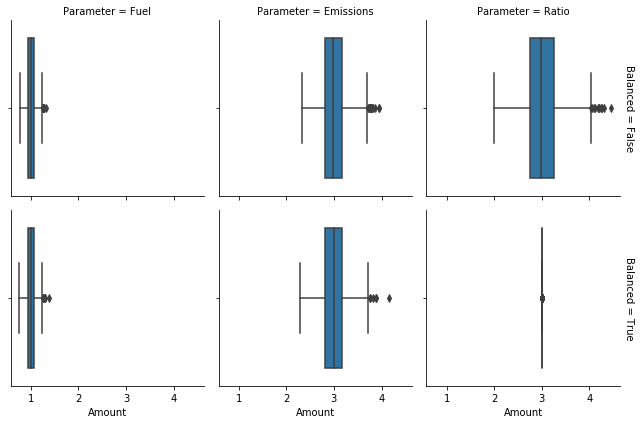

In [126]:
g = sns.FacetGrid(df, row="Balanced", col="Parameter", margin_titles=True)
g.map(sns.boxplot, "Amount", orient='V')
g.savefig(r"../source/images/eg4_plot.jpeg")

In [102]:
ratio_balanced.min(), ratio_balanced.max(), 

(2.9999999999999996, 3.0000000000000004)

In [41]:
fuel_consumption

array([1.0530212 , 0.92752258, 0.89529092, 0.84222057, 1.12408009,
       0.79263305, 0.92868245, 1.03090234, 0.76801553, 0.94224468])

In [ ]:
for i in range(10):
    next(mc)
    print("iteration: ", i,"\n\tindexer count: ", mc.presamples.matrix_indexer[0].count,"\n\tindexer index: ", mc.presamples.matrix_indexer[0].index)

In [ ]:
lca = bw.LCA({('db1', 'b'):1}, presamples=[time_pp_path], method=("mock method", "pollutant emission"))

In [ ]:
lca.presamples.reset_sequential_indices()

In [ ]:
print("iteration\tindex")
for i in range(time_array.shape[1]):
    lca.presamples.update_matrices()
    lca.lci()
    print(i, "\t\t", lca.presamples.matrix_indexer[0].index)
    #print("iteration: ", i,"\n\tindexer count: ", lca.presamples.matrix_indexer[0].count,"\n\tindexer index: ", lca.presamples.matrix_indexer[0].index)

In [ ]:
for i in range(time_array.shape[1]):
    if i == 0:
        print(i, lca.presamples.matrix_indexer[0].count, lca.presamples.matrix_indexer[0].index)
        lca.lci()
        A, _, _, _ = format_matrices(lca=lca)
        matrix_to_plot(A)
    else:
        lca.presamples.update_matrices()
        print(i, lca.presamples.matrix_indexer[0].count, lca.presamples.matrix_indexer[0].index)
        lca.lci()
        A, _, _, _ = format_matrices(lca=lca)
        matrix_to_plot(A)

In [ ]:

if 
lca.presamples.update_package_indices()
lca.presamples.matrix_indexer[0].count

In [ ]:
lca.lci()

In [ ]:
lca.presamples.update_matrices()

In [ ]:
lca.presamples.update_package_indices()

In [ ]:
lca.presamples.advance_indices

In [ ]:
lca = bw.LCA({('db1', 'b'):1}, presamples=[time_pp_path], method=("mock method", "pollutant emission"))
for t in range(time_array.shape[1]):
    print("time step", t)
    lca.load_lci_data()
    lca.lci()
    lca.lcia()
    print(lca.score)
    A, _, _, _ = format_matrices(lca=lca)
    matrix_to_plot(
        A, 
        return_fig=True, 
        title="Technosphere matrix \n{}\nTime step {}".format("A", t), 
        save_path=r"../source/images/eg2_A_{}.jpg".format(t));

In [ ]:
indexer = lca.presamples.matrix_indexer[0]

In [ ]:
next(indexer)
indexer.index

## LCA matrices and the case for using presamples

At its barest expression, LCA models can be represented with three matrices and a vector:

 * the technosphere matrix $\mathbf{A}$, describing the links among activities in the technosphere (technosphere exchanges)
 * the biosphere matrix $\mathbf{B}$, satellite matrix describing the exchanges between the activities and the environment (elementary flows)
 * the characterization matrix $\mathbf{C}$, giving unit impact factors for elementary flows with the environment (characterisation factors)
 * the final demand vector **f**

An impact score per functional unit is given by $\mathbf{g} = \mathbf{CBA^{-1}f}$

Presamples can replace values in any these matrices as calculations are carried out.

Storing and injecting specific values in LCA matrices can improve LCA calculations in many ways:

  * Storing and reusing data characterizing given scenarios makes scenario analysis much easier.
  * It can easily integrate time series.
  * It can use pre-generated static or stochastic values that were generated by complex, non-linear models, allowing the
    LCA model to capture system dynamics more accurately.
  * It is possible to account to correlation across parameters during Monte Carlo Simulations (e.g. for correlation
    between characterization factors, between fuel use and CO2 emissions, etc.
  * Since sampled data can be used directly, it is unnecessary to fit data to a distribution.

## Defining the input matrix_data

GET FROM RST

### Formating functions (Notebook version only)

The following functions were written to format some of the objects that are encountered in LCA.  
These are presented here, but are excluded from the documentation found on [readthedocs](https://presamples.readthedocs.io/).  
If you prefer a less cluttered view of the use of presamples, we suggest you visit the docs instead.  

In [ ]:
# Import required modules
import numpy as np
import pandas as pd
# The matrices used in the example are not sparse, so we ignore the SparseEfficiencyWarning
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning) 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Format matrices to DataFrame
def format_matrices(database=None, demand=None, lca=None):
    if lca is None:
        if demand is None:
            act = bw.Database(database).random()
            demand={act:act.get('production amount', 1)}
        lca = bw.LCA(demand)
    lca.lci()
    rev_activity_dict, rev_product_dict, rev_bio_dict = lca.reverse_dict()
    def get_name_with_units(act_key):
        act = bw.get_activity(act_key)
        return "\n{} ({})\n{}\n".format(act['name'], act['unit'], act.key)
    
    col_names = [get_name_with_units(rev_activity_dict[i]) for i in np.arange(lca.inventory.shape[1])]
    techno_row_names = [get_name_with_units(rev_product_dict[i]) for i in np.arange(lca.technosphere_matrix.shape[0])]
    bio_row_names = [get_name_with_units(rev_bio_dict[i]) for i in np.arange(lca.biosphere_matrix.shape[0])]
    lca.demand_array = np.eye(lca.technosphere_matrix.shape[0])
    A_formatted = pd.DataFrame(index=techno_row_names, columns=col_names, data=lca.technosphere_matrix.todense())
    B_formatted = pd.DataFrame(index=bio_row_names, columns=col_names, data=lca.biosphere_matrix.todense())
    #TODO CHANGE NAMES
    S = lca.solve_linear_system()
    G = lca.biosphere_matrix * S
    invA_formatted = pd.DataFrame(index=col_names, columns=techno_row_names, data=S)
    G_formatted = pd.DataFrame(index=bio_row_names, columns=col_names, data=G)
    return A_formatted, B_formatted, invA_formatted, G_formatted

def format_matrices_simple(database=None, demand=None, lca=None):
    if lca is None:
        if demand is None:
            act = bw.Database(database).random()
            demand={act:act.get('production amount', 1)}
        lca = bw.LCA(demand)
    lca.lci()
    rev_activity_dict, rev_product_dict, rev_bio_dict = lca.reverse_dict()
    def get_name_with_units(act_key):
        act = bw.get_activity(act_key)
        return "\n{}\n{}\n".format(act.key, act['unit'])
    
    col_names = [get_name_with_units(rev_activity_dict[i]) for i in np.arange(lca.inventory.shape[1])]
    techno_row_names = [get_name_with_units(rev_product_dict[i]) for i in np.arange(lca.technosphere_matrix.shape[0])]
    bio_row_names = [get_name_with_units(rev_bio_dict[i]) for i in np.arange(lca.biosphere_matrix.shape[0])]
    lca.demand_array = np.eye(lca.technosphere_matrix.shape[0])
    A_formatted = pd.DataFrame(index=techno_row_names, columns=col_names, data=lca.technosphere_matrix.todense())
    B_formatted = pd.DataFrame(index=bio_row_names, columns=col_names, data=lca.biosphere_matrix.todense())
    #TODO CHANGE NAMES
    S = lca.solve_linear_system()
    G = lca.biosphere_matrix * S
    invA_formatted = pd.DataFrame(index=col_names, columns=techno_row_names, data=S)
    G_formatted = pd.DataFrame(index=bio_row_names, columns=col_names, data=G)
    return A_formatted, B_formatted, invA_formatted, G_formatted


# Format matrices to figure
def matrix_to_plot(matrix_as_df, return_fig=True, title=None, save_path=None, title_size=14, scaling_ratio=4):
    w = 2 + matrix_as_df.shape[1]/scaling_ratio
    h = 2 + matrix_as_df.shape[0]/scaling_ratio
    plt.figure(figsize=(w,h))
    matrix_plot = sns.heatmap(
        matrix_as_df, annot=True, cbar=False, cmap=(['white']), 
        mask=(matrix_as_df==0).values, linewidths=1, linecolor='grey',
        square=True
    )
    fig = matrix_plot.get_figure()
    if title:
        plt.title(title, fontsize=title_size)
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", ext="jpg")
    if return_fig:
        return fig

In [ ]:
import brightway2 as bw
bw.projects.set_current("presamples doc")
bio = bw.Database("bio")
bio.register()
bio.write({
    ("bio", "emission"): {
        'categories': ['water'],
        'name': 'Some emission',
        'type': 'emission',
        'unit': 'kg'
    },
    ("bio", "water in"): {
        'categories': ['natural resource'],
        'exchanges': [],
        'name': 'Water in',
        'type': 'natural resource',
        'unit': 'm3'
    },
    ("bio", "water out"): {
        'categories': ['water'],
        'exchanges': [],
        'name': 'Water out',
        'type': 'emission',
        'unit': 'm3'
    },
    ("bio", "land from"): {
        'categories': ('natural resource', 'land'),
        'exchanges': [],
        'name': 'Transformation, from x',
        'type': 'natural resource',
        'unit': 'm2'
    },
    ("bio", "land to"): {
        'categories': ('natural resource', 'land'),
        'exchanges': [],
        'name': 'Transformation, to y',
        'type': 'natural resource',
        'unit': 'm2'
    },
})

## Example 1 - Static scenario analysis: changing supplier

In [ ]:
my_db = bw.Database('db1')
my_db.register()
my_db.write({
    ('db1', "a1"): {
        'type': 'process',
        'name': 'a, producer a1',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'a',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'comment': 'Normal activity, uncertainty lognormal',
        'exchanges': [
            {
                'name': 'a',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db1', 'a1'),
                'type': 'production',
                'uncertainty type': 0,
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 1,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
                'uncertainty type': 2,
                'loc': np.log(1),
                'scale': 0.1,
            },
            {
                'name': 'land from',
                'unit': 'square meter',
                'amount': 1,
                'input': ('bio', 'land from'),
                'type': 'biosphere',
                'uncertainty type': 5,
                'loc': 1,
                'minimum': 0.5,
                'maximum': 1.5,
            },
            {
                'name': 'land to',
                'unit': 'square meter',
                'amount': 1,
                'input': ('bio', 'land to'),
                'type': 'biosphere',
                'uncertainty type': 5,
                'loc': 1,
                'minimum': 0.5,
                'maximum': 1.5,
            },
            {
                'name': 'water in',
                'unit': 'cubic meter',
                'amount': 1,
                'input': ('bio', 'water in'),
                'type': 'biosphere',
                'uncertainty type': 2,
                'loc': np.log(1),
                'scale': 0.1,
            },
            {
                'name': 'water out',
                'unit': 'cubic meter',
                'amount': 1,
                'input': ('bio', 'water out'),
                'type': 'biosphere',
                'uncertainty type': 2,
                'loc': np.log(1),
                'scale': 0.1,
            }
        ],
    },
    ('db1', "a2"): {
        'type': 'process',
        'name': 'a, producer a2',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'a',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'comment': 'Normal activity, uncertainty triangular',
        'exchanges': [
            {
                'name': 't',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db1', 'a2'),
                'type': 'production',
                'uncertainty type': 0,
            },
            {
                'name': 'Some emission',
                'unit': 'kg',
                'amount': 2,
                'input': ('bio', 'emission'),
                'type': 'biosphere',
                'uncertainty type': 5,
                'loc': 2,
                'minimum': 1,
                'maximum': 3,
            },
            {
                'name': 'land from',
                'unit': 'square meter',
                'amount': 1,
                'input': ('bio', 'land from'),
                'type': 'biosphere',
                'uncertainty type': 5,
                'loc': 1,
                'minimum': 0.5,
                'maximum': 1.5,
            },
            {
                'name': 'land to',
                'unit': 'square meter',
                'amount': 1,
                'input': ('bio', 'land to'),
                'type': 'biosphere',
                'uncertainty type': 5,
                'loc': 1,
                'minimum': 0.5,
                'maximum': 1.5,
            },
            {
                'name': 'water in',
                'unit': 'cubic meter',
                'amount': 1,
                'input': ('bio', 'water in'),
                'type': 'biosphere',
                'uncertainty type': 2,
                'loc': np.log(1),
                'scale': 0.1,
            },
            {
                'name': 'water out',
                'unit': 'cubic meter',
                'amount': 1,
                'input': ('bio', 'water out'),
                'type': 'biosphere',
                'uncertainty type': 2,
                'loc': np.log(1),
                'scale': 0.1,
            }
        ],
    },
    ('db1', "b"): {
        'type': 'process',
        'name': 'x, producer b',
        'unit': 'kg',
        'location': 'GLO',
        'reference product': 'x',
        'production amount': 1,
        'activity type': 'ordinary transforming activity',
        'exchanges': [
            {
                'name': 'x',
                'unit': 'kg',
                'amount': 1.0,
                'input': ('db1', 'b'),
                'type': 'production',
                'uncertainty type': 0,
            },
            {
                'name': 'a',
                'unit': 'kg',
                'amount': 0.6,
                'input': ('db1', 'a1'),
                'type': 'technosphere',
                'uncertainty type': 2,
                'loc': np.log(0.6),
                'scale': 0.1
            },
            {
                'name': 'a', # input from a2
                'unit': 'kg',
                'amount': 0.4,
                'input': ('db1', 'a2'),
                'type': 'technosphere',
                'uncertainty type': 2,
                'loc': np.log(0.4),
                'scale': 0.1
            },
        ],
    },
})


In [ ]:
A_formatted, B_formatted, invA_formatted, G_formatted = format_matrices_simple(database='db1')

In [ ]:
matrix_to_plot(A_formatted, title=None, save_path=r"../source/images/bw2_eg1_A_orig.jpeg");

In [ ]:
matrix_data = [
    (np.array((0, 1)).reshape(-1, 1), 
     [
         (('db1', 'a1'), ('db1', 'b'), 'technosphere'),
         (('db1', 'a2'), ('db1', 'b'), 'technosphere'),
     ],
     'technosphere'
    )
]

In [ ]:
import presamples as ps

In [ ]:
_, pp_path = ps.create_presamples_package(matrix_data=matrix_data)

In [ ]:
pp_path

In [ ]:
lca = bw.LCA({('db1', 'b'): 1}, presamples=[pp_path])

In [ ]:
A_formatted_w_ps, B_formatted_w_ps, invA_formatted_w_ps, G_formatted_w_ps = format_matrices_simple(lca=lca)

In [ ]:
matrix_to_plot(A_formatted_w_ps, save_path=r"../source/images/eg1_A_after.jpeg");

## Simple database used in documentation 

We need some life cycle inventory (LCI) data to showcase the use of `presamples`. We use a very simple set of fake
activities contained in a database "db":

![title](../data/A_as_diagram.jpg)

The importing of "db" in Brightway2 is done in another Notebook, available [here](https://github.com/PascalLesage/presamples/blob/master/docs/notebooks/Importing_sample_databases_for_documentation.ipynb). You need to run that other Notebook in order to import the data on your own computer.  
Once imported, you can access the database by setting your current brightway project to the one where the data was imported ("presamples doc" if you followed along in the other notebook).

In [ ]:
# Import Brightway2 and switch to project with the sample databases:
import brightway2 as bw
bw.projects.set_current("presamples doc")
bw.databases

The actual data contained in the database can be presented via the technosphere $\mathbf{A}$ and biosphere $\mathbf{B}$ matrices. In the following matrix images, row and column headers show both the name and the key of the activity or elementary flow. 

In [ ]:
# Generate DataFrame versions of the matrices
A, B, _, _ = format_matrices(database='db1')
matrix_to_plot(A, return_fig=True, title="Technosphere matrix \n$\mathbf{A}$", save_path=r"../data/A.jpg");

In [ ]:
# Plot the A matrix
matrix_to_plot(A, return_fig=True, title="Technosphere matrix \n$\mathbf{A}$", save_path=r"../data/A.jpg");

In [ ]:
# Plot the B matrix
matrix_to_plot(B, return_fig=True, title="Biosphere matrix \n$\mathbf{B}$", save_path=r"../data/B.jpg");

## Run through

To create a presample package, one needs to pass:
  - information about matrix indices,  
  - values for the cells at these matrix indices.  

Take a simple case: we want to (attributionally) analyse a scenario where production activity prod_A1 begins to send all its waste to treatment activity treat_W1. This can be done by replacing two numbers in the A matrix. 
- The exchange from prod_A1 to market_A is set to 0  
- The exchange from prod_A1 to treat_W1 is set to 1

The corresponding matrix indices and samples (in this case, one single observation per parameter) are defined as follows: 

Import packages:

In [ ]:
import presamples as ps

In [ ]:
indices = [
    (('my database', 'treat_1'), ('my database', 'prod_A1'), 'technosphere'),
    (('my database', 'treat_market'), ('my database', 'prod_A1'), 'technosphere'),
]
samples = np.array([-0.2, 0]).reshape(-1, 1)

In [ ]:
ps_id, ps_path = ps.create_presamples_package(matrix_data=[(samples, indices, 'technosphere')])

In [ ]:
lca = bw.LCA({('my database', 'prod_Amarket'): 1}, method=('fake method', 'emission'))
lca_with_presamples = bw.LCA({('my database', 'prod_Amarket'):1}, presamples=[ps_path], method=('fake method', 'emission',))

In [ ]:
lca.lci()
lca_with_presamples.lci()
lca.lcia()
lca_with_presamples.lcia()

In [ ]:
lca_with_presamples.technosphere_matrix.todense()==lca.technosphere_matrix.todense()

In [ ]:
A, B, invA, G = format_matrices(lca)

In [ ]:
format_A_matrix(lca).loc[:, str(bw.get_activity(('my database', 'prod_A1')))]

In [ ]:
format_A_matrix(lca_with_presamples).loc[:, str(bw.get_activity(('my database', 'prod_A1')))]

In [ ]:
lca_with_presamples.score/lca.score

## Passing matrix data to presample creation

SEE NOTEBOOK FOR FULL DESCIPTIONS  
To write presamples, one must provide two things: 
- Values, with each row representing a cell in a given matrix and each column one set of values for these cells; 
- Indices, which inform the matrix and the matrix coordinates that the values correspond to.  

Values are stored in 

Suppose we want to (attributionally) analyse the scenario where production activity prod_A1 begins to send all its waste to treatment activity treat_W1. This can be done by replacing two numbers in the A matrix:  
- The exchange from prod_A1 to market_A is set to 0  
- The exchange from prod_A1 to treat_W1 is set to 1  

This scenario can be expressed as a combination of values (0, 1) and matrix indices for a given matrix (A).

## Using presamples in LCA

## Using presamples in MonteCarloLCA

## Fixed sum helper model

## Kronecker delta helper model

## Parameterized brightway models